# 视频动作识别
视频动作识别是指对一小段视频中的内容进行分析，判断视频中的人物做了哪种动作。视频动作识别与图像领域的图像识别，既有联系又有区别，图像识别是对一张静态图片进行识别，而视频动作识别不仅要考察每张图片的静态内容，还要考察不同图片静态内容之间的时空关系。比如一个人扶着一扇半开的门，仅凭这一张图片无法判断该动作是开门动作还是关门动作。

视频分析领域的研究相比较图像分析领域的研究，发展时间更短，也更有难度。视频分析模型完成的难点首先在于，需要强大的计算资源来完成视频的分析。视频要拆解成为图像进行分析，导致模型的数据量十分庞大。视频内容有很重要的考虑因素是动作的时间顺序，需要将视频转换成的图像通过时间关系联系起来，做出判断，所以模型需要考虑时序因素，加入时间维度之后参数也会大量增加。

得益于PASCAL VOC、ImageNet、MS COCO等数据集的公开，图像领域产生了很多的经典模型，那么在视频分析领域有没有什么经典的数据集和模型呢？答案是有的，本案例将为大家介绍视频动作识别领域的经典数据集和经典模型。

由于本案例的代码是在华为云ModelArts Notebook上运行，所以需要先按照如下步骤来进行Notebook环境的准备。

### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个Notebook开发环境，ModelArts Notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 action_recognition |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | 本案例使用较为复杂的深度神经网络模型，需要较高算力，选择"GPU" |
| 规格 | 选择"8核 &#124; 64GiB &#124; 1*p100" |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好Notebook参数后，点击下一步，进入Notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![enter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"action_recognition"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

### 准备源代码和数据

这一步准备案例所需的源代码和数据，相关资源已经保存在OBS中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。解压后，当前目录包含data、dataset_subset和其他目录文件，分布是预训练参数文件、数据集和代码文件等。

In [1]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path="ai-course-common-26-bj4/video/video.tar.gz", path="./video.tar.gz")
# 使用tar命令解压资源包
!tar xf ./video.tar.gz
# 使用rm命令删除压缩包
!rm ./video.tar.gz

Successfully download file ai-course-common-26-bj4/video/video.tar.gz from OBS to local ./video.tar.gz


## 数据集介绍

在这部分我们将介绍3个视频内容的数据集：HMDB51、UCF-101和Kinetics。

数据集在模型的训练过程中，起到了十分重要的作用。好的数据集可以让模型有更好的表现，所以数据集的选择和质量非常重要。

### HMDB51
HMDB51是布朗大学在2011年发布的视频数据集，视频来源于电影、公共数据库和YouTube等网络视频库。HMDB作为一个人类动作视频数据，包含6849段视频剪辑，51个人类动作类别，每类动作至少包含101段视频剪辑。[HMDB51数据集官网](https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/)。

动作主要分为五类：

- 一般面部动作微笑，如：大笑，咀嚼，交谈。
- 面部操作与对象操作：如：吸烟，吃，喝。
-  一般的身体动作：如：侧手翻，拍手，爬。
- 与对象交互动作：如：梳头，抓，运球。
- 人体动作：如：击剑，拥抱，踢某人。 

![image.png](./img/hmdb_1.png)
![image.png](./img/hmdb_0.png)

### UCF-101 动作识别数据集

UCF-101是一种现实动作视频的动作识别数据集，来源于YouTube，一共有101个动作类别，13320个视频。UCF101在动作和表达上的多样性丰富，考虑到相机的移动，目标的表现和动作，目标的大小，视角，北京，光照条件等等，所以数据集充满了挑战性。[UCF-101数据集官网](https://www.crcv.ucf.edu/data/UCF101.php)。

UCF-101的视频类别可以分为25组，每一组包括4-7种视频动作，同组视频有相同的特征，比如相似的背景，相似的视角等等。

所有的视频类别可以分为5类： 1）人-对象 交互 2）只有动作 3） 人-人交互 4）乐器演奏 5）运动

![image.png](./img/ucf.png)

### Kinetics 数据集

ActivityNet是一项视频分类的比赛，与图像理解的ImageNet比赛类似，吸引了大量学者的关注和参与。在行为理解比赛项目下，使用的数据集为Kinetcs。数据集由Google的deepmind团队提供，2017年是第一届比赛，有400个类别，20多万数据，2018年又对数据集进行了扩增，有600个类别，共50万左右的视频，截止到2020年2月，现在的Kinetics最新版本为Kinetics-700，包含了将近650,000 个视频的URL，覆盖了700个人物动作类型，所有的视频来自YouTube网站，视频至少为10秒。Kinetics数据集在视频分析领域的地位就相当于ImageNet图像分析领域的地位，是一个真正大规模的视频数据集。[Kinetics-700数据集官网](https://deepmind.com/research/open-source/kinetics)。

由于Kinetics数据集太大，所以本案例选用了UCF-101数据集的部分子集作为演示用数据集，接下来，我们播放一段UCF-101中的视频：

In [2]:
video_name = "./data/v_TaiChi_g01_c01.avi"

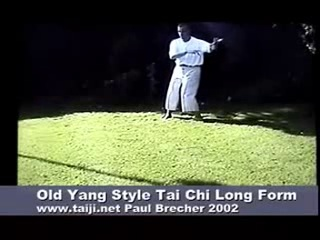

In [3]:
from IPython.display import clear_output, Image, display, HTML
import time
import cv2
import base64
import numpy as np

def arrayShow(img):
    _,ret = cv2.imencode('.jpg', img) 
    return Image(data=ret) 

cap = cv2.VideoCapture(video_name)

while True:
    try:
        clear_output(wait=True)
        ret, frame = cap.read()
        if ret:
            tmp = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = arrayShow(frame)
            display(img)
            time.sleep(0.05)
        else:
            break
    except KeyboardInterrupt:
        cap.release()
cap.release()

## 视频动作识别模型介绍

在图像领域中，ImageNet作为一个大型图像识别数据集，自2010年开始，使用此数据集训练出的图像算法层出不穷，深度学习模型经历了从AlexNet到VGG-16再到更加复杂的结构，模型的表现也越来越好。在识别千种类别的图片时，错误率表现如下：

<img src="./img/ImageNet.png" width="500" height="500" align=center>

在图像识别中表现很好的模型，可以在图像领域的其他任务中继续使用，通过复用模型中部分层的参数，就可以提升模型的训练效果。有了基于ImageNet模型的图像模型，很多模型和任务都有了更好的训练基础，比如说物体检测、实例分割、人脸检测、人脸识别等。

那么训练效果显著的图像模型是否可以用于视频模型的训练呢？答案是yes，有研究证明，在视频领域，如果能够复用图像模型结构，甚至参数，将对视频模型的训练有很大帮助。但是怎样才能复用上图像模型的结构呢？首先需要知道视频分类与图像分类的不同，如果将视频视作是图像的集合，每一个帧将作为一个图像，视频分类任务除了要考虑到图像中的表现，也要考虑图像间的时空关系，才可以对视频动作进行分类。

为了捕获图像间的时空关系，论文[I3D](https://arxiv.org/pdf/1705.07750.pdf)介绍了三种旧的视频分类模型，并提出了一种更有效的Two-Stream Inflated 3D ConvNets（简称I3D）的模型，下面将逐一简介这四种模型，更多细节信息请查看原论文。

### 旧模型一：卷积网络+LSTM

模型使用了训练成熟的图像模型，通过卷积网络，对每一帧图像进行特征提取、池化和预测，最后在模型的末端加一个LSTM层（长短期记忆网络），如下图所示，这样就可以使模型能够考虑时间性结构，将上下文特征联系起来，做出动作判断。这种模型的缺点是只能捕获较大的工作，对小动作的识别效果较差，而且由于视频中的每一帧图像都要经过网络的计算，所以训练时间很长。

<img src="./img/video_model_0.png" width="200" height="200" align=center>

### 旧模型二：3D卷积网络

3D卷积类似于2D卷积，将时序信息加入卷积操作。虽然这是一种看起来更加自然的视频处理方式，但是由于卷积核维度增加，参数的数量也增加了，模型的训练变得更加困难。这种模型没有对图像模型进行复用，而是直接将视频数据传入3D卷积网络进行训练。

<img src="./img/video_model_1.png" width="150" height="150" align=center>

### 旧模型三：Two-Stream 网络

Two-Stream 网络的两个流分别为**1张RGB快照**和**10张计算之后的光流帧画面组成的栈**。两个流都通过ImageNet预训练好的图像卷积网络，光流部分可以分为竖直和水平两个通道，所以是普通图片输入的2倍，模型在训练和测试中表现都十分出色。

<img src="./img/video_model_2.png" width="400" height="400" align=center>

#### 光流视频 optical flow video

上面讲到了光流，在此对光流做一下介绍。光流是什么呢？名字很专业，感觉很陌生，但实际上这种视觉现象我们每天都在经历，我们坐高铁的时候，可以看到窗外的景物都在快速往后退，开得越快，就感受到外面的景物就是“刷”地一个残影，这种视觉上目标的运动方向和速度就是光流。光流从概念上讲，是对物体运动的观察，通过找到相邻帧之间的相关性来判断帧之间的对应关系，计算出相邻帧画面中物体的运动信息，获取像素运动的瞬时速度。在原始视频中，有运动部分和静止的背景部分，我们通常需要判断的只是视频中运动部分的状态，而光流就是通过计算得到了视频中运动部分的运动信息。

下面是一个经过计算后的原视频及光流视频。

原视频
![See videos/v_CricketShot_g04_c01_rgb.gif](./img/v_CricketShot_g04_c01_rgb.gif)
光流视频
![See videos/v_CricketShot_g04_c01_flow.gif](./img/v_CricketShot_g04_c01_flow.gif)

### 新模型：Two-Stream Inflated 3D ConvNets

新模型采取了以下几点结构改进：
   - 拓展2D卷积为3D。直接利用成熟的图像分类模型，只不过将网络中二维N * N的 filters 和 pooling kernels 直接变成N * N * N；
   - 用 2D filter 的预训练参数来初始化 3D filter 的参数。上一步已经利用了图像分类模型的网络，这一步的目的是能利用上网络的预训练参数，直接将 2D filter 的参数直接沿着第三个时间维度进行复制N次，最后将所有参数值再除以N；
   - 调整感受野的形状和大小。新模型改造了图像分类模型Inception-v1的结构，前两个max-pooling层改成使用 1 * 3 * 3 kernels and stride 1 in time，其他所有max-pooling层都仍然使用对此的kernel和stride，最后一个average pooling层使用 2 * 7 * 7 的kernal。
   - 延续了Two-Stream的基本方法。用双流结构来捕获图片之间的时空关系仍然是有效的。

最后新模型的整体结构如下图所示：

<img src="./img/video_model_3.png" width="200" height="200" align=center>

好，到目前为止，我们已经讲解了视频动作识别的经典数据集和经典模型，下面我们通过代码来实践地跑一跑其中的两个模型：**C3D模型**（ 3D卷积网络）以及**I3D模型**（Two-Stream Inflated 3D ConvNets）。

### C3D模型结构


我们已经在前面的“旧模型二：3D卷积网络”中讲解到3D卷积网络是一种看起来比较自然的处理视频的网络，虽然它有效果不够好，计算量也大的特点，但它的结构很简单，可以构造一个很简单的网络就可以实现视频动作识别，如下图所示是3D卷积的示意图：

![image.png](./img/c3d_0.png)

a)中，一张图片进行了2D卷积， b)中，对视频进行2D卷积，将多个帧视作多个通道， c)中，对视频进行3D卷积，将时序信息加入输入信号中。

ab中，output都是一张二维特征图，所以无论是输入是否有时间信息，输出都是一张二维的特征图，2D卷积失去了时序信息。只有3D卷积在输出时，保留了时序信息。2D和3D池化操作同样有这样的问题。

如下图所示是一种[C3D](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)网络的变种：（如需阅读原文描述，请查看I3D论文 2.2 节）

![image.png](./img/c3d_1.png)

C3D结构，包括8个卷积层，5个最大池化层以及2个全连接层，最后是softmax输出层。

所有的3D卷积核为$ 3 × 3 × 3$ 步长为1，使用SGD，初始学习率为0.003，每150k个迭代，除以2。优化在1.9M个迭代的时候结束，大约13epoch。

数据处理时，视频抽帧定义大小为：$ c × l × h × w$，$c$为通道数量，$l$为帧的数量，$h$为帧画面的高度，$w$为帧画面的宽度。3D卷积核和池化核的大小为$ d × k × k$，$d$是核的时间深度，$k$是核的空间大小。网络的输入为视频的抽帧，预测出的是类别标签。所有的视频帧画面都调整大小为$ 128 × 171 $，几乎将UCF-101数据集中的帧调整为一半大小。视频被分为不重复的16帧画面，这些画面将作为模型网络的输入。最后对帧画面的大小进行裁剪，输入的数据为$16 × 112 × 112 $

### C3D模型训练
接下来，我们将对C3D模型进行训练，训练过程分为：数据预处理以及模型训练。在此次训练中，我们使用的数据集为UCF-101，由于C3D模型的输入是视频的每帧图片，因此我们需要对数据集的视频进行抽帧，也就是将视频转换为图片，然后将图片数据传入模型之中，进行训练。

在本案例中，我们随机抽取了UCF-101数据集的一部分进行训练的演示，感兴趣的同学可以下载完整的UCF-101数据集进行训练。

[UCF-101下载](https://www.crcv.ucf.edu/data/UCF101.php)

数据集存储在目录` dataset_subset`下

如下代码是使用cv2库进行视频文件到图片文件的转换

In [4]:
import cv2
import os
# 视频数据集存储位置
video_path = './dataset_subset/'
# 生成的图像数据集存储位置
save_path = './dataset/'
# 如果文件路径不存在则创建路径
if os.path.exists(save_path) == False:
    os.mkdir(save_path)

In [5]:
# 获取动作列表
action_list = os.listdir(video_path)
# 遍历所有动作
for action in action_list:
    if action.startswith(".")==False:
        if not os.path.exists(save_path+action):
            os.mkdir(save_path+action)
        video_list = os.listdir(video_path+action)
        # 遍历所有视频
        for video in video_list:
            prefix = video.split('.')[0]
            if not os.path.exists(save_path+action+'/'+prefix):
                os.mkdir(save_path+action+'/'+prefix)
            save_name = save_path + action + '/' + prefix + '/'
            video_name = video_path+action+'/'+video
            # 读取视频文件
            # cap为视频的帧
            cap = cv2.VideoCapture(video_name)
            # fps为帧率
            fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps_count = 0
            for i in range(fps):
                ret, frame = cap.read()
                if ret:
                    # 将帧画面写入图片文件中
                    cv2.imwrite(save_name+str(10000+fps_count)+'.jpg',frame)
                    fps_count += 1

此时，视频逐帧转换成的图片数据已经存储起来，为模型训练做准备。

### 模型训练
首先，我们构建模型结构。

C3D模型结构我们之前已经介绍过，这里我们通过`keras`提供的Conv3D，MaxPool3D，ZeroPadding3D等函数进行模型的搭建。

In [6]:
from keras.layers import Dense,Dropout,Conv3D,Input,MaxPool3D,Flatten,Activation, ZeroPadding3D
from keras.regularizers import l2
from keras.models import Model, Sequential

# 输入数据为 112×112 的图片，16帧， 3通道
input_shape = (112,112,16,3)
# 权重衰减率
weight_decay = 0.005
# 类型数量，我们使用UCF-101 为数据集，所以为101
nb_classes = 101

# 构建模型结构
inputs = Input(input_shape)

x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
           activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
x = MaxPool3D((2,2,1),strides=(2,2,1),padding='same')(x)

x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
           activation='relu',kernel_regularizer=l2(weight_decay))(x)
x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
           activation='relu',kernel_regularizer=l2(weight_decay))(x)
x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

x = Conv3D(256,(3,3,3),strides=(1,1,1),padding='same',
           activation='relu',kernel_regularizer=l2(weight_decay))(x)
x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

x = Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same',
           activation='relu',kernel_regularizer=l2(weight_decay))(x)
x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(2048,activation='relu',kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.5)(x)
x = Dense(2048,activation='relu',kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.5)(x)
x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
x = Activation('softmax')(x)

model = Model(inputs, x)

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


通过keras提供的`summary()`方法，打印模型结构。可以看到模型的层构建以及各层的输入输出情况。

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 16, 3)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 112, 112, 16, 64)  5248      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 56, 56, 16, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 56, 56, 16, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 28, 28, 8, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 28, 28, 8, 128)    442496    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 14, 14, 4, 128)    0         
__________

通过keras的`input`方法可以查看模型的输入形状，shape分别为`( batch size, width, height, frames, channels) ` 。

In [8]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 112, 112, 16, 3) dtype=float32>

可以看到模型的数据处理的维度与图像处理模型有一些差别，多了frames维度，体现出时序关系在视频分析中的影响。

接下来，我们开始将图片文件转为训练需要的数据形式。

In [9]:
# 引用必要的库
from keras.optimizers import SGD,Adam
from keras.utils import np_utils

import numpy as np
import random
import cv2

import matplotlib.pyplot as plt

# 自定义callbacks
from schedules import onetenth_4_8_12

参数定义

In [10]:
img_path = save_path  # 图片文件存储位置
results_path = './results'  # 训练结果保存位置
if not os.path.exists(results_path):
    os.mkdir(results_path)

数据集划分，随机抽取4/5 作为训练集，其余为验证集。将文件信息分别存储在`train_list`和`test_list`中，为训练做准备。

In [11]:
cates = os.listdir(img_path)
train_list = []
test_list = []
# 遍历所有的动作类型
for cate in cates:
    videos = os.listdir(os.path.join(img_path, cate))
    length = len(videos)//5
    # 训练集大小，随机取视频文件加入训练集
    train= random.sample(videos, length*4)
    train_list.extend(train)
    # 将余下的视频加入测试集
    for video in videos:
        if video not in train:
            test_list.append(video)
print("训练集为：")    
print( train_list)
print("共%d 个视频\n"%(len(train_list)))
print("验证集为：")            
print(test_list)
print("共%d 个视频"%(len(test_list)))

训练集为：
['v_Bowling_g04_c04', 'v_Bowling_g05_c07', 'v_Bowling_g03_c06', 'v_Bowling_g04_c03', 'v_Bowling_g01_c07', 'v_Bowling_g05_c01', 'v_Bowling_g05_c06', 'v_Bowling_g06_c06', 'v_Bowling_g06_c04', 'v_Bowling_g06_c02', 'v_Bowling_g06_c07', 'v_Bowling_g03_c07', 'v_Bowling_g05_c03', 'v_Bowling_g06_c05', 'v_Bowling_g05_c05', 'v_Bowling_g04_c02', 'v_Bowling_g03_c05', 'v_Bowling_g02_c01', 'v_Bowling_g06_c01', 'v_Bowling_g06_c03', 'v_Bowling_g05_c04', 'v_Bowling_g05_c02', 'v_Bowling_g02_c04', 'v_Bowling_g02_c02', 'v_Fencing_g13_c04', 'v_Fencing_g08_c03', 'v_Fencing_g11_c01', 'v_Fencing_g11_c04', 'v_Fencing_g10_c03', 'v_Fencing_g10_c01', 'v_Fencing_g13_c03', 'v_Fencing_g12_c05', 'v_Fencing_g12_c02', 'v_Fencing_g10_c04', 'v_Fencing_g13_c01', 'v_Fencing_g11_c05', 'v_Fencing_g08_c04', 'v_Fencing_g12_c04', 'v_Fencing_g10_c05', 'v_Fencing_g13_c02', 'v_Fencing_g09_c03', 'v_Fencing_g14_c03', 'v_Fencing_g09_c05', 'v_Fencing_g11_c02', 'v_Fencing_g09_c02', 'v_Fencing_g15_c01', 'v_Fencing_g10_c02', 'v_Fen

接下来开始进行模型的训练。

首先定义数据读取方法。方法`process_data`中读取一个batch的数据，包含16帧的图片信息的数据，以及数据的标注信息。在读取图片数据时，对图片进行随机裁剪和翻转操作以完成数据增广。

In [12]:
def process_data(img_path, file_list,batch_size=16,train=True):
    batch = np.zeros((batch_size,16,112,112,3),dtype='float32')
    labels = np.zeros(batch_size,dtype='int')
    cate_list = os.listdir(img_path)
    
    def read_classes():
        path = "./classInd.txt"
        with open(path, "r+") as f:
            lines = f.readlines()
        classes = {}
        for line in lines:
            c_id = line.split()[0]
            c_name = line.split()[1]
            classes[c_name] =c_id 
        return classes
        
    classes_dict = read_classes()
    
    for file in file_list:
        cate = file.split("_")[1]
        img_list = os.listdir(os.path.join(img_path, cate, file))
        img_list.sort()
        batch_img = []
        for i in range(batch_size):
            path = os.path.join(img_path, cate, file)
            label =  int(classes_dict[cate])-1
            symbol = len(img_list)//16
            if train:
                # 随机进行裁剪
                crop_x = random.randint(0, 15)
                crop_y = random.randint(0, 58)
                # 随机进行翻转
                is_flip = random.randint(0, 1)
                # 以16 帧为单位
                for j in range(16):
                    img = img_list[symbol + j]
                    image = cv2.imread( path + '/' + img)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (171, 128))
                    if is_flip == 1:
                        image = cv2.flip(image, 1)
                    batch[i][j][:][:][:] = image[crop_x:crop_x + 112, crop_y:crop_y + 112, :]
                    symbol-=1
                    if symbol<0:
                        break
                labels[i] = label
            else:
                for j in range(16):
                    img = img_list[symbol + j]
                    image = cv2.imread( path + '/' + img)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (171, 128))
                    batch[i][j][:][:][:] = image[8:120, 30:142, :]
                    symbol-=1
                    if symbol<0:
                        break
                labels[i] = label
    return batch, labels

In [13]:
batch, labels = process_data(img_path, train_list)

print("每个batch的形状为：%s"%(str(batch.shape)))
print("每个label的形状为：%s"%(str(labels.shape)))

每个batch的形状为：(16, 16, 112, 112, 3)
每个label的形状为：(16,)


定义data generator， 将数据批次传入训练函数中。

In [14]:
def generator_train_batch(train_list, batch_size, num_classes, img_path):
    while True:
        # 读取一个batch的数据
        x_train, x_labels = process_data(img_path, train_list, batch_size=16,train=True)
        x = preprocess(x_train)
        # 形成input要求的数据格式
        y = np_utils.to_categorical(np.array(x_labels), num_classes)
        x = np.transpose(x, (0,2,3,1,4))
        yield x, y
def generator_val_batch(test_list, batch_size, num_classes, img_path):
    while True:
        # 读取一个batch的数据
        y_test,y_labels = process_data(img_path, train_list, batch_size=16,train=False)
        x = preprocess(y_test)
        # 形成input要求的数据格式
        x = np.transpose(x,(0,2,3,1,4))
        y = np_utils.to_categorical(np.array(y_labels), num_classes)
        yield x, y

定义方法`preprocess`， 对函数的输入数据进行图像的标准化处理。

In [15]:
def preprocess(inputs):
    inputs[..., 0] -= 99.9
    inputs[..., 1] -= 92.1
    inputs[..., 2] -= 82.6
    inputs[..., 0] /= 65.8
    inputs[..., 1] /= 62.3
    inputs[..., 2] /= 60.3
    return inputs

In [16]:
# 类别数量
num_classes = 101
# batch大小
batch_size = 4
# epoch数量
epochs = 1
# 学习率大小
lr = 0.005
# 优化器定义
sgd = SGD(lr=lr, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# 开始训练
history = model.fit_generator(generator_train_batch(train_list, batch_size, num_classes,img_path),
                              steps_per_epoch= len(train_list) // batch_size,
                              epochs=epochs,
                              callbacks=[onetenth_4_8_12(lr)],
                              validation_data=generator_val_batch(test_list, batch_size,num_classes,img_path),
                              validation_steps= len(test_list) // batch_size,
                              verbose=1)
# 对训练结果进行保存
model.save_weights(os.path.join(results_path, 'weights_c3d.h5'))

Instructions for updating:
Use tf.cast instead.


Epoch 1/1
18/18 [==============================] - 232s 13s/step - loss: 28.6410 - acc: 0.9236 - val_loss: 27.7856 - val_acc: 1.0000


## 模型测试
接下来我们将训练之后得到的模型进行测试。随机在UCF-101中选择一个视频文件作为测试数据，然后对视频进行取帧，每16帧画面传入模型进行一次动作预测，并且将动作预测以及预测百分比打印在画面中并进行视频播放。

首先，引入相关的库。

In [17]:
from IPython.display import clear_output, Image, display, HTML
import time
import cv2
import base64
import numpy as np

构建模型结构并且加载权重。

In [18]:
from models import c3d_model
model = c3d_model()
model.load_weights(os.path.join(results_path, 'weights_c3d.h5'), by_name=True)  # 加载刚训练的模型

定义函数arrayshow，进行图片变量的编码格式转换。

In [19]:
def arrayShow(img):
    _,ret = cv2.imencode('.jpg', img) 
    return Image(data=ret) 

进行视频的预处理以及预测，将预测结果打印到画面中，最后进行播放。

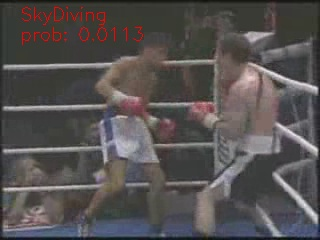

In [20]:
# 加载所有的类别和编号
with open('./ucfTrainTestlist/classInd.txt', 'r') as f:
    class_names = f.readlines()
    f.close()
# 读取视频文件
video = './videos/v_Punch_g03_c01.avi'
cap = cv2.VideoCapture(video)
clip = []
# 将视频画面传入模型
while True:
    try:
        clear_output(wait=True)
        ret, frame = cap.read()
        if ret:
            tmp = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            clip.append(cv2.resize(tmp, (171, 128)))
            # 每16帧进行一次预测
            if len(clip) == 16:
                inputs = np.array(clip).astype(np.float32)
                inputs = np.expand_dims(inputs, axis=0)
                inputs[..., 0] -= 99.9
                inputs[..., 1] -= 92.1
                inputs[..., 2] -= 82.6
                inputs[..., 0] /= 65.8
                inputs[..., 1] /= 62.3
                inputs[..., 2] /= 60.3
                inputs = inputs[:,:,8:120,30:142,:]
                inputs = np.transpose(inputs, (0, 2, 3, 1, 4))
                # 获得预测结果
                pred = model.predict(inputs)
                label = np.argmax(pred[0])
                # 将预测结果绘制到画面中
                cv2.putText(frame, class_names[label].split(' ')[-1].strip(), (20, 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                            (0, 0, 255), 1)
                cv2.putText(frame, "prob: %.4f" % pred[0][label], (20, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                            (0, 0, 255), 1)
                clip.pop(0)
            # 播放预测后的视频    
            lines, columns, _ = frame.shape
            frame = cv2.resize(frame, (int(columns), int(lines)))
            img = arrayShow(frame)
            display(img)
            time.sleep(0.02)
        else:
            break
    except:
        print(0)
cap.release()

## I3D 模型

在之前我们简单介绍了I3D模型，[I3D官方github库](https://github.com/deepmind/kinetics-i3d)提供了在Kinetics上预训练的模型和预测代码，接下来我们将体验I3D模型如何对视频进行预测。

首先，引入相关的包

In [21]:
import numpy as np
import tensorflow as tf

import i3d


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



进行参数的定义

In [22]:
# 输入图片大小
_IMAGE_SIZE = 224
#  视频的帧数
_SAMPLE_VIDEO_FRAMES = 79

# 输入数据包括两部分：RGB和光流
# RGB和光流数据已经经过提前计算
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}
# 提供了多种可以选择的预训练权重
# 其中，imagenet系列模型从ImageNet的2D权重中拓展而来，其余为视频数据下的预训练权重
_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}
# 记录类别文件
_LABEL_MAP_PATH = 'data/label_map.txt'
# 类别数量为400
NUM_CLASSES = 400

定义参数：
- imagenet_pretrained ：如果为`True`，则调用预训练权重，如果为`False`，则调用ImageNet转成的权重

In [23]:
imagenet_pretrained = True

In [24]:
# 加载动作类型
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
tf.logging.set_verbosity(tf.logging.INFO)

构建RGB部分模型

In [25]:
rgb_input = tf.placeholder(tf.float32, shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))

with tf.variable_scope('RGB'):
    rgb_model = i3d.InceptionI3d(NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
    rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)

rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
        
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

构建光流部分模型

In [26]:
flow_input = tf.placeholder(tf.float32,shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 2))

with tf.variable_scope('Flow'):
    flow_model = i3d.InceptionI3d(NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
    flow_logits, _ = flow_model(flow_input, is_training=False, dropout_keep_prob=1.0)
flow_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'Flow':
        flow_variable_map[variable.name.replace(':0', '')] = variable
flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)    

将模型联合，成为完整的I3D模型

In [27]:
model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

开始模型预测,获得视频动作预测结果。
预测数据为开篇提供的RGB和光流数据：

![See videos/v_CricketShot_g04_c01_rgb.gif](./img/v_CricketShot_g04_c01_rgb.gif)

![See videos/v_CricketShot_g04_c01_flow.gif](./img/v_CricketShot_g04_c01_flow.gif)

In [44]:
with tf.Session() as sess:
    feed_dict = {}
    
    if imagenet_pretrained:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
    else:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
        
    tf.logging.info('RGB checkpoint restored')
    rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
    tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
    feed_dict[rgb_input] = rgb_sample
    
    if imagenet_pretrained:
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
    else:
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
        
    tf.logging.info('Flow checkpoint restored')
    flow_sample = np.load(_SAMPLE_PATHS['flow'])
    tf.logging.info('Flow data loaded, shape=%s', str(flow_sample.shape))
    feed_dict[flow_input] = flow_sample

    out_logits, out_predictions = sess.run(
        [model_logits, model_predictions],
        feed_dict=feed_dict)

    out_logits = out_logits[0]
    out_predictions = out_predictions[0]
    sorted_indices = np.argsort(out_predictions)[::-1]

    print('Norm of logits: %f' % np.linalg.norm(out_logits))
    print('\nTop classes and probabilities')
    for index in sorted_indices[:20]:
        print(out_predictions[index], out_logits[index], kinetics_classes[index])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468689

Top classes and probabilities
1.0 41.813683 playing cricket
1.497162e-09 21.493988 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.5492213e-10 19.225584 catching or throwing softball
1.1360078e-10 18.915352 hitting baseball
8.8011216e-11 18.660126 playing tennis
2.4415511e-11 17.37788 playing kickball
1.1531971e-11 16.627785 playing squash or racquetball
6.131901e-12 15.996165 shooting goal (soccer)
4.3917357e-12 15.662386 hammer throw
2.2134141e-12 14.977198 golf putting
1.6307001e-12 1